In [1]:
# default_exp unsupervised
# default_cls_lvl 2

# Chapter 9. Unsupervised Learning
>

- Although most of the applications of machine learning algorithms today are based on supervised learning, The vast majority of the available data is **unlabeled**.
- We have the input $X$, but we don't have the labels $y$.
- Yann LeCun: "If intelligence was a cake, **Unsupervised Learning** would be the **cake**, **supervised learning** would be the **icing** on the cake, and **reinforcement learning** would be the **cherry** on the cake."
- In this chapter we will look at a few unsupervised learning tasks and algorithms:
    - Clustering: the goal is to group similar instances together into clusters.
        - Clustering is a great tool for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning,..
    - Anomaly Detection: This is the task of estimating the probability density function of the random process that generated the dataset.
        - Instances located in very low-density regions are likley to be anomalies.

## Clustering

- Clustering: identifying groups containing similar objects.
- Consider the example of unsupervised clustering the Iris dataset
    - If we remove its labels, we can't use classification algorithms.
    - Unsupervised Learning Clustering make use of all available features to located clusters and assign all instances to one of them.
        - Using a Gaussian Mixture Model, only 5/150 are assigned to the wrong cluster.
- Clustering is used in:
    - Customer Segmentation
    - Data Analysis
        - It might be useful to cluster the instance and analyse each separately.
- Dimensionality Reduction
    - By replacing the features with each instance's affinity to each cluster.
- Anomaly Detection
    - Any instance that have low affinity to all clusters is likely to be an outlier.
- Semi-supervised Learning
    - If you have a few labels, you can perform clustering and propagate the available labels to other instances within the clusters.
- Search Engines
    - Image similarity search: clustering available images & when a new item is provided by the user, cluster it using the same algorithm and return the top N centered items.
- To segment an image
    - By clustering pixels according to their color, then replacing pixel colors with the mean of its cluster.
- There are different types of clustering algorithms and there isn't a universal definition of what a cluster is.
- In this section, we will look at two widely used unsupervised learning clustering algorithms, the first one is `KMeans` and the second is `DBSCAN`.

### K-Means

- Let's start with makes some data:

In [7]:
from sklearn import datasets
import matplotlib.pyplot as plt

In [10]:
X, y = datasets.make_blobs(n_samples=1000, n_features=2, centers=5, cluster_std=[0.5, 0.5, 0.5, 1, 1])

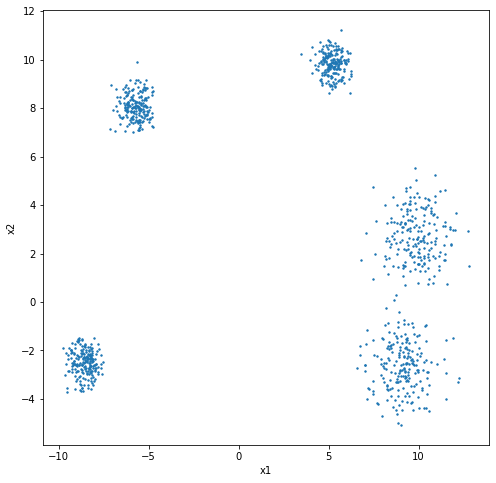

In [13]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], s=2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

- Let's train a k-means clusterer on this dataset.

In [14]:
from sklearn.cluster import KMeans

In [15]:
k = 5

In [16]:
kmeans = KMeans(n_clusters=k)

In [17]:
y_pred = kmeans.fit_predict(X)

- Note that you have to specify the number of clusters to be found.


In [22]:
y_pred is kmeans.labels_

True

- We can also take a look at the five centroids the algorithm found:

In [23]:
kmeans.cluster_centers_

array([[-5.72145452,  8.06318529],
       [ 9.08886397, -2.65499205],
       [ 5.19265013,  9.82116385],
       [-8.57302108, -2.51073088],
       [ 9.86723132,  2.72503967]])

- We can easily predict the cluster of new instances:

In [24]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])

In [25]:
kmeans.predict(X_new)

array([0, 4, 0, 0], dtype=int32)

- By plotting the algorithm's decision boundaries, we get a Voronoi tesselation:

In [26]:
# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

In [28]:
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

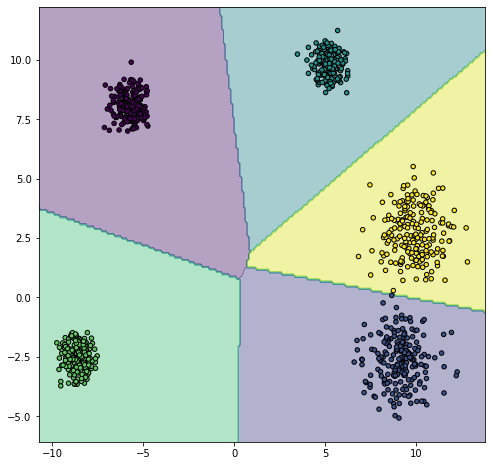

In [34]:
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=20, edgecolor='k')
plt.show()

- The vast majority of the instances were clearly assigned to their original cluster.
- All KMeans cares about is the distance between instances and the centroids.
- Instead of assigning each instance to a cluster (hard clustering) it's better to give a per-instance cluster score (soft clustering).
    - The score can be the distance between the instance and the centroids.
        - This can also be a good dimensionality reduction technique.
- In `sklearn`, the `transform` method measures the distance between each instance and the centroids.

In [36]:
kmeans.transform(X_new)

array([[ 8.33650153, 10.21158162,  9.38798271,  9.68727947,  9.89383325],
       [10.62195768,  7.66441227,  8.12270389, 12.42101083,  6.90539995],
       [ 5.74823103, 13.34614428, 10.66057186,  7.83751994, 12.8701688 ],
       [ 6.19316924, 13.14209173, 10.98721786,  7.4943971 , 12.86919907]])

### `KMeans` Algorithm

- How does the algorithm work?
- Suppose you were given the centroids.
- You could easily label all the instances in the dataset by assigning each of them to the cluster with the closest centroid.
- Conversely, if you were given all the instance labels, you could easily locate all the centroids by computing the mean of the instances within each cluster.
- ...